In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf

## Infected and News

In [114]:
df = pd.read_csv('../seir/cov_datasets/all.csv')
#df.rename(columns={"Unnamed: 0": "Date","binary_score (1:good   0: bad)": "Score"}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
print(df.shape)
print(df.dtypes)
df.head()

(555, 4)
Date                     datetime64[ns]
Cummulative_Deaths              float64
Infected                        float64
Cummulative_Recovered           float64
dtype: object


,Date,Cummulative_Deaths,Infected,Cummulative_Recovered
0,2020-02-14,1.0,5.0,12.0
1,2020-02-15,1.0,4.0,12.0
2,2020-02-16,1.0,1.0,13.0
3,2020-02-17,1.0,6.0,12.0
4,2020-02-18,1.0,8.0,14.0


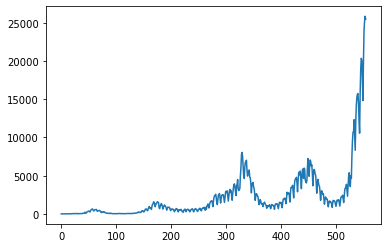

In [115]:
plt.plot(df['Infected'])

### Let's get back to the basics, only use the infected feature

In [125]:
def spilt_seq(seq, n_steps_in, n_steps_out):
    X = []
    y = []
    for i in range(len(seq)):
        x_end_idx = i + n_steps_in
        y_start_idx = x_end_idx + n_steps_out
        if(y_start_idx > len(seq)):
            break
        X.append(seq[i:x_end_idx])
        y.append(seq[x_end_idx:y_start_idx])
    return np.array(X), np.array(y)


In [134]:
sc = MinMaxScaler(feature_range = (0, 1))
data = df['Infected'].values.reshape(len(df), 1)

infected_scaled = sc.fit_transform(data).reshape(len(df))

print(infected_scaled.shape)

(555,)


In [224]:
n_steps_in = 30
n_steps_out = 5 # forcast 5 steps into the future
X, y = spilt_seq(infected_scaled,n_steps_in,n_steps_out)
X = X.reshape(X.shape[0], X.shape[1], 1) # samples, timesteps, features
y = y.reshape(y.shape[0], y.shape[1], 1) 

print(X.shape)
print(y.shape)

(521, 30, 1)
(521, 5, 1)


In [225]:
X_train = X[:400,:]
X_test  = X[400:,:]
y_train = y[:400,:]
y_test  = y[400:,:]

In [226]:
input_shape = (X_train.shape[1],X_train.shape[2])
input_shape

(30, 1)

In [227]:
model = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, activation='relu', input_shape = input_shape))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True,activation='relu'))
model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, activation='relu'))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, activation='relu'))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = n_steps_out, activation='relu'))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_absolute_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 20, batch_size = 128)

Epoch 1/20
4/4 [==============================] - 0s 49ms/step - loss: 0.0503
Epoch 2/20
4/4 [==============================] - 0s 47ms/step - loss: 0.0456
Epoch 3/20
4/4 [==============================] - 0s 49ms/step - loss: 0.0421
Epoch 4/20
4/4 [==============================] - 0s 48ms/step - loss: 0.0406
Epoch 5/20
4/4 [==============================] - 0s 53ms/step - loss: 0.0377
Epoch 6/20
4/4 [==============================] - 0s 50ms/step - loss: 0.0348
Epoch 7/20
4/4 [==============================] - 0s 49ms/step - loss: 0.0312
Epoch 8/20
4/4 [==============================] - 0s 45ms/step - loss: 0.0299
Epoch 9/20
4/4 [==============================] - 0s 45ms/step - loss: 0.0296
Epoch 10/20
4/4 [==============================] - 0s 45ms/step - loss: 0.0281
Epoch 11/20
4/4 [==============================] - 0s 45ms/step - loss: 0.0268
Epoch 12/20
4/4 [==============================] - 0s 48ms/step - loss: 0.0269
Epoch 13/20
4/4 [==============================] - 0s 46ms/st

In [228]:
y_pred = model.predict(X_test)
y_pred = sc.inverse_transform(y_pred) #revert scaling
#print(sc.inverse_transform(y_pred))

In [229]:
print(y_pred.shape)

(121, 5)


In [230]:
y_test_reshaped = y_test.reshape(-1)

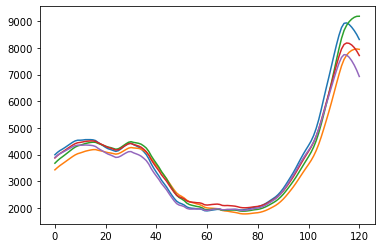

In [231]:
plt.plot(y_pred)

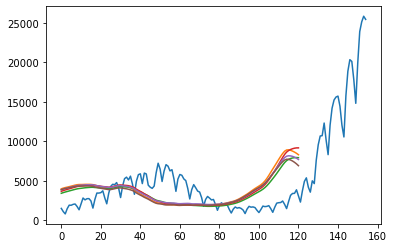

In [232]:
plt.plot(df['Infected'][400:].reset_index().drop(['index'],axis = 1))
plt.plot(y_pred)